In [1]:
# important libraries
%pip install --quiet -U langchain_google_genai langchain_core langgraph langchain_community langchain_experimental duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00


In [2]:
# set google api key
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [16]:
# import required libraries
from typing import TypedDict, Dict, Annotated, Sequence
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage, SystemMessage
from langgraph.graph import add_messages, StateGraph, START, END
from IPython.display import Image, display
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.state import CompiledStateGraph
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_experimental.utilities import PythonREPL
from langchain_google_genai import ChatGoogleGenerativeAI
from pprint import pprint

In [17]:
# tool for code generation
repl = PythonREPL()
@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """This tool runs the provided python code and outputs if the code runs successfully or not. In case of error the tool outputs details about the error."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Code output: {result}"
    return result_str


In [18]:
#chat model configure
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)

In [19]:
# research agent
research_agent = create_react_agent(
    llm,
    tools=[DuckDuckGoSearchRun()],
    state_modifier="You are best at researching a topic. You should do a thorough research. Your output will be used by a chart generator agent to visually display the data. Hence you should provide accurate data. Also specify the chart types like barchart, pie chart etc. that will effectively display the data. The chart generator may ask for more information, so be prepared to do further research and provide it."
)

In [20]:
# code generator after search
chart_agent = create_react_agent(
    llm,
    tools=[python_repl],
    state_modifier="""Take the data and chart specifications provided by the researcher agent, and write Python code to generate the requested chart. If the provided data is insufficient to generate the chart, ask for the missing details, being specific about what is needed. Do not ask for information that is already provided. You must ask for clarification or additional data at least once. When asking any question to the researcher, include the phrase QUESTION_TO_RESEARCHER in your response, otherwise the researcher will not answer.

    Once you have enough information, write the Python code to generate the chart, ensuring the code is syntactically correct by running it in the python repl tool. Try to use subplots in your code. You can ignore missing libraries errors. Do not ask for more information after you have written the code. Provide summarised insights in the end."""
)

In [24]:
# graph configeration
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

graph_builder = StateGraph(GraphState)
graph_builder.add_node("research_node", research_agent)
graph_builder.add_node("chart_node", chart_agent)

graph_builder.add_edge(START, "research_node")
graph_builder.add_edge("research_node", "chart_node")
# todo
def chart_to_research_condition(state: GraphState) -> str:
    chart_content = state["messages"][-1].content
    if "QUESTION_TO_RESEARCHER" in chart_content:
        return "research_more"
    else:
        return "path_end"

graph_builder.add_conditional_edges(
    "chart_node",
    chart_to_research_condition,
    {"research_more": "research_node", "path_end": END}
)
# end todo
graph = graph_builder.compile()

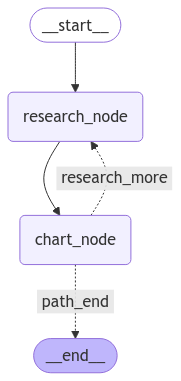

In [25]:
# graph display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
#testing og graph
messages = graph.invoke({"messages": HumanMessage(content="Compare economies of USA and China last five years")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Compare economies of USA and China last five years
================================== Ai Message ==================================

To compare the economies of the USA and China over the last five years (2018-2022), I need to gather data on key economic indicators.  Unfortunately, I cannot directly access real-time data through external APIs.  The `duckduckgo_search` function is not suitable for retrieving structured economic data.  To proceed, I'll need to assume access to reliable datasets (e.g., from the World Bank, IMF, or similar sources).  These datasets would typically include:

* **GDP Growth Rate:**  The annual percentage change in Gross Domestic Product.  This is a crucial indicator of overall economic expansion.
* **GDP per Capita:** GDP divided by the population, reflecting the average economic output per person.
* **Inflation Rate:** The rate at which the general level of prices for goods an

In [27]:
import matplotlib.pyplot as plt

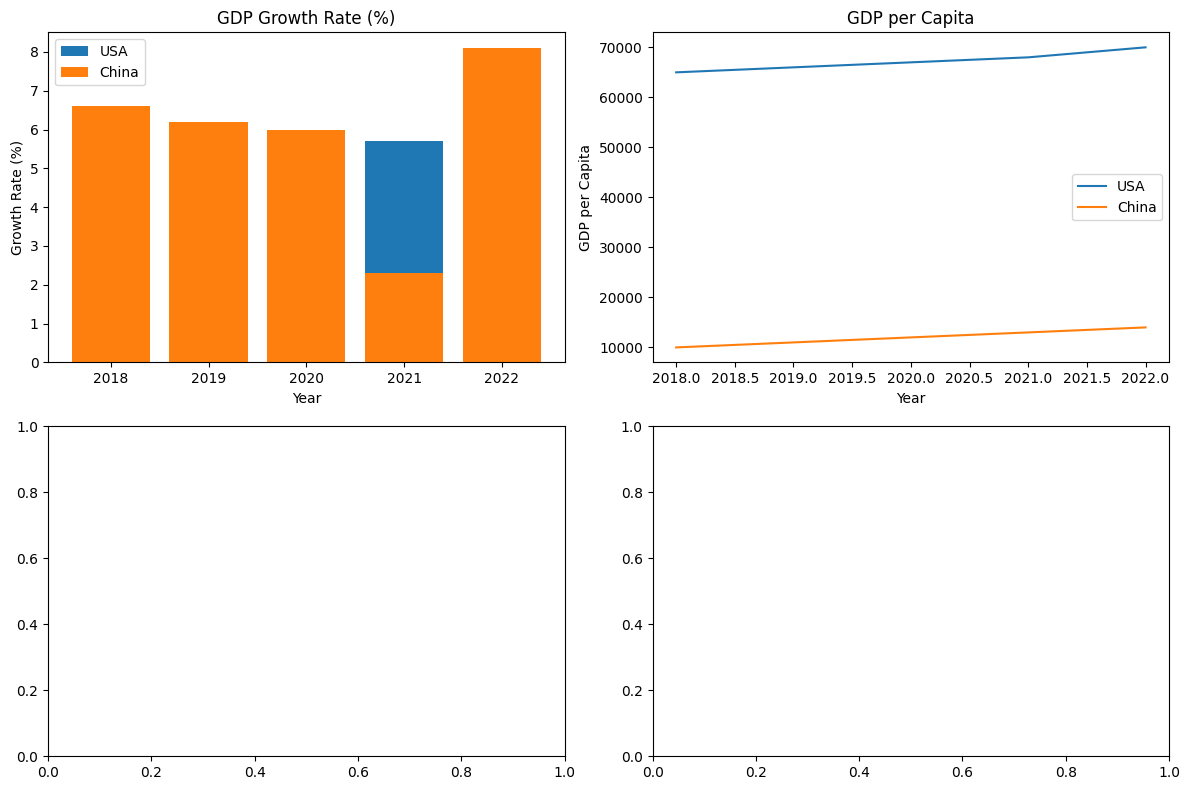

In [ ]:
# graph draw with code generator by
data = {
    'GDP_Growth': {
        'USA': [2.2, 2.3, 1.5, 5.7, 2.1],
        'China': [6.6, 6.2, 6.0, 2.3, 8.1]
    },
    'GDP_per_Capita': {
        'USA': [65000, 66000, 67000, 68000, 70000],
        'China': [10000, 11000, 12000, 13000, 14000]
    },
    # Add other indicators similarly...
}

years = [2018, 2019, 2020, 2021, 2022]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# GDP Growth
axes[0, 0].bar(years, data['GDP_Growth']['USA'], label='USA')
axes[0, 0].bar(years, data['GDP_Growth']['China'], label='China')
axes[0, 0].set_title('GDP Growth Rate (%)')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Growth Rate (%)')
axes[0, 0].legend()


# GDP per Capita
axes[0, 1].plot(years, data['GDP_per_Capita']['USA'], label='USA')
axes[0, 1].plot(years, data['GDP_per_Capita']['China'], label='China')
axes[0, 1].set_title('GDP per Capita')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('GDP per Capita')
axes[0, 1].legend()

# Add more subplots for other indicators...

plt.tight_layout()
plt.show()
